In [1]:
import torch
from matplotlib import pyplot as plt
import sys
import time
import os
import numpy as np


#####################################################
# In this notebook, we train a 3-layer linear transformer with
# - context-length 20
# - covariate dimension 5, standard Gaussian distribution
# We plot
# - test loss against number of iterations
# - imshow of each parameter matrix at end of training
# - distance-to-identity of each parameter matrix
#####################################################

#use cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.cuda.set_device(1)
# import the model and some useful functions
from linear_transformer import Transformer_F, attention, generate_data, in_context_loss

# set up some print options
np.set_printoptions(precision = 2, suppress = True)
torch.set_printoptions(precision=2)

#begin logging
log_dir = 'log' 
#exp_dir = 'simple_demonstration' 
cur_dir = log_dir #os.path.join(log_dir, exp_dir)
os.makedirs(cur_dir, exist_ok=True)
#f = open(cur_dir + '/train.log', "a", 1)
#sys.stdout = f

In [2]:
# Set up problem parameters

lr = 0.001
clip_r = 1000
alg = 'adam'
mode = 'normal'

n_layer = 3  # number of layers of transformer
N = 20     # context length
d = 5        # dimension


n_head = 1  # 1-headed attention
B = 4000  # 1000 minibatch size
var = 0.0001  # initializations scale of transformer parameter
shape_k = 0.1  # shape_k: parameter for Gamma distributed covariates
max_iters = 10000  # Number of Iterations to run
hist_stride = 1  # stride for saved model paramters in `train.ipynb'
stride = 100

# a convenience function for taking a step and clipping
def clip_and_step(allparam, optimizer, clip_r = None):
    norm_p=None
    grad_all = allparam.grad
    if clip_r is not None:
        norm_p = grad_all.norm().item()
        if norm_p > clip_r:
            grad_all.mul_(clip_r/norm_p)
    optimizer.step()
    return norm_p

In [3]:
filename_format = '/linearTF_exp_{}_{}_{}.pth'
filename = filename_format.format(n_layer, N, d)
filename = (cur_dir + filename)
hist_dict = {}


seeds = [0,1,2] #for demonstration purpose, just use 3 seeds
keys = [(s,) for s in seeds]
for key in keys:
    sd = key[0]
    
    prob_seed = sd
    opt_seed = sd
    
    hist_dict[key] = []
    
    #set seed and initialize model
    torch.manual_seed(opt_seed)
    model = Transformer_F(n_layer, 1, d, var)
    model.to(device)
    #initialize algorithm. Important: set beta = 0.9 for adam, 0.999 is very slow
    if alg == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0)
    elif alg == 'adam':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.9), weight_decay=0)
    else: assert False
    
    #set seed and initialize initial training batch
    np.random.seed(prob_seed)
    torch.manual_seed(prob_seed)
    
    for t in range(max_iters):
        start = time.time()
        # save model parameters
        if t%hist_stride ==0:
            hist_dict[key].append(model.allparam.clone().detach())
        #  generate a new batch of training set
        Z, y = generate_data(mode,N,d,B,shape_k)
        Z = Z.to(device)
        y = y.to(device)
        loss = in_context_loss(model, Z, y)
        
        # compute gradient, take step
        loss.backward()
        norms = clip_and_step(model.allparam, optimizer, clip_r=clip_r)
        optimizer.zero_grad()
        end=time.time()
        if t%100 ==0 or t<5:
            print('iter {} | Loss: {}  time: {}  gradnorm: {}'.format(t,loss.item(), end-start, norms))
    #save to 
torch.save({'hist_dict':hist_dict}, filename)

iter 0 | Loss: 5.274078369140625  time: 0.5430207252502441  gradnorm: 8.325983047485352
iter 1 | Loss: 5.042016983032227  time: 0.020655155181884766  gradnorm: 7.863056182861328
iter 2 | Loss: 4.906970024108887  time: 0.013690948486328125  gradnorm: 7.567624092102051
iter 3 | Loss: 4.815439224243164  time: 0.0090484619140625  gradnorm: 7.383678913116455
iter 4 | Loss: 4.964611530303955  time: 0.009352922439575195  gradnorm: 7.7818922996521
iter 100 | Loss: 2.773015260696411  time: 0.006732463836669922  gradnorm: 4.2411088943481445
iter 200 | Loss: 1.4974335432052612  time: 0.006808042526245117  gradnorm: 2.154644727706909
iter 300 | Loss: 0.8171159029006958  time: 0.007788658142089844  gradnorm: 0.9908329248428345
iter 400 | Loss: 0.6241925358772278  time: 0.007343292236328125  gradnorm: 0.5734948515892029
iter 500 | Loss: 0.5343747138977051  time: 0.006792306900024414  gradnorm: 0.5081468224525452
iter 600 | Loss: 0.4207223057746887  time: 0.0068819522857666016  gradnorm: 1.1449096202

iter 8100 | Loss: 0.0013542722444981337  time: 0.006814479827880859  gradnorm: 0.008755416609346867
iter 8200 | Loss: 0.00190800242125988  time: 0.007160663604736328  gradnorm: 0.015115005895495415
iter 8300 | Loss: 0.0013444754295051098  time: 0.006810188293457031  gradnorm: 0.007294510491192341
iter 8400 | Loss: 0.001613057916983962  time: 0.007176399230957031  gradnorm: 0.010910668410360813
iter 8500 | Loss: 0.0019335151882842183  time: 0.006799221038818359  gradnorm: 0.053295329213142395
iter 8600 | Loss: 0.002083886880427599  time: 0.007161617279052734  gradnorm: 0.06664495915174484
iter 8700 | Loss: 0.0009201219072565436  time: 0.006975412368774414  gradnorm: 0.007963789626955986
iter 8800 | Loss: 0.001239779987372458  time: 0.006936550140380859  gradnorm: 0.007708278018981218
iter 8900 | Loss: 0.0018177443416789174  time: 0.006747245788574219  gradnorm: 0.013950852677226067
iter 9000 | Loss: 0.0013717713300138712  time: 0.007777214050292969  gradnorm: 0.006715038325637579
iter 9

iter 6200 | Loss: 0.002952525857836008  time: 0.007445812225341797  gradnorm: 0.020299481227993965
iter 6300 | Loss: 0.0025415169075131416  time: 0.0077931880950927734  gradnorm: 0.01747393049299717
iter 6400 | Loss: 0.003423903603106737  time: 0.006896018981933594  gradnorm: 0.01872173137962818
iter 6500 | Loss: 0.002048035152256489  time: 0.007075071334838867  gradnorm: 0.01797366328537464
iter 6600 | Loss: 0.0020063878037035465  time: 0.006878852844238281  gradnorm: 0.017099419608712196
iter 6700 | Loss: 0.0051406328566372395  time: 0.00689697265625  gradnorm: 0.11810237169265747
iter 6800 | Loss: 0.002642445033416152  time: 0.006968259811401367  gradnorm: 0.013853023760020733
iter 6900 | Loss: 0.0033428932074457407  time: 0.007378816604614258  gradnorm: 0.03208388015627861
iter 7000 | Loss: 0.001850197440944612  time: 0.00801849365234375  gradnorm: 0.021661436185240746
iter 7100 | Loss: 0.0028796554543077946  time: 0.0068585872650146484  gradnorm: 0.029453907161951065
iter 7200 | L

iter 4300 | Loss: 0.011050252243876457  time: 0.006902933120727539  gradnorm: 0.023648899048566818
iter 4400 | Loss: 0.006869933567941189  time: 0.0075836181640625  gradnorm: 0.02599608525633812
iter 4500 | Loss: 0.007051758002489805  time: 0.006928682327270508  gradnorm: 0.027942949905991554
iter 4600 | Loss: 0.008085774257779121  time: 0.007019758224487305  gradnorm: 0.011178281158208847
iter 4700 | Loss: 0.007572832517325878  time: 0.007022380828857422  gradnorm: 0.02373528480529785
iter 4800 | Loss: 0.007400340400636196  time: 0.006902933120727539  gradnorm: 0.025067294016480446
iter 4900 | Loss: 0.005314594600349665  time: 0.0070648193359375  gradnorm: 0.01173456571996212
iter 5000 | Loss: 0.00930083729326725  time: 0.0070438385009765625  gradnorm: 0.046141982078552246
iter 5100 | Loss: 0.006154762580990791  time: 0.00690770149230957  gradnorm: 0.0447259321808815
iter 5200 | Loss: 0.004004959017038345  time: 0.007058858871459961  gradnorm: 0.01680767349898815
iter 5300 | Loss: 0.0

In [4]:
####################################
# compute test loss
####################################
hist_dict = torch.load(filename)['hist_dict']
loss_dict = {}
for key in hist_dict:
    sd = key[0]
    
    loss_dict[key] = torch.zeros(max_iters//stride)
    
    np.random.seed(99)
    torch.manual_seed(99)
    Z, y = generate_data(mode,N,d,B,shape_k)
    Z = Z.to(device)
    y = y.to(device)
    model = Transformer_F(n_layer, n_head, d, var).to(device)
    for t in range(0,max_iters,stride):
        with torch.no_grad():
            model.allparam.copy_(hist_dict[key][t])
        loss_dict[key][t//stride] = in_context_loss(model, Z, y).item()

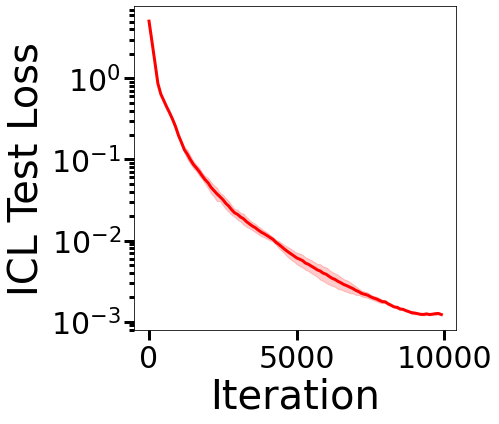

In [5]:
####################################
# plot the test loss with error bars
####################################

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, ax = plt.subplots(1, 1,figsize = (7, 6))

losses = torch.zeros(len(seeds), max_iters//stride)
keys = loss_dict.keys()
for idx, key in enumerate(keys):
    losses[idx,:] = loss_dict[key]
losses_mean = torch.mean(losses, axis=0)
losses_std = torch.std(losses, axis=0)
ax.plot(range(0,max_iters,stride), losses_mean, color = 'red', lw = 3)#, label='Adam')
ax.fill_between(range(0,max_iters,stride), losses_mean-losses_std, losses_mean+losses_std, color = 'red', alpha = 0.2)
ax.set_xlabel('Iteration',fontsize=40)
ax.set_ylabel('ICL Test Loss',fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
#ax.legend(fontsize=30)
ax.set_yscale('log')


plt.tight_layout()
plt.savefig(fig_dir + '/simple_demonstration_loss_plot.pdf', dpi=600)

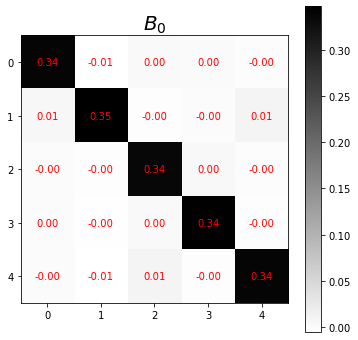

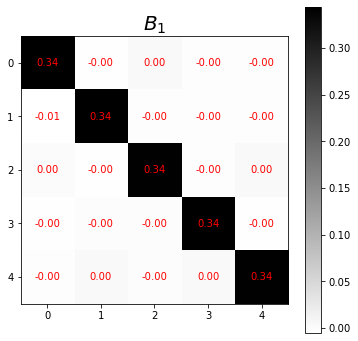

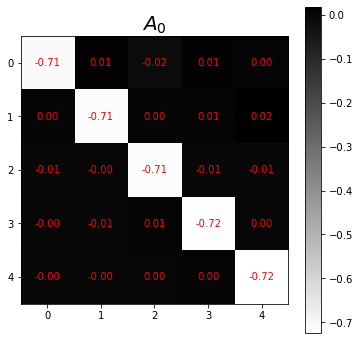

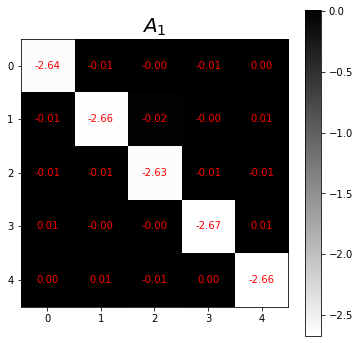

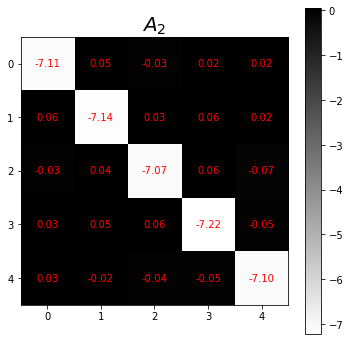

In [6]:
####################################
# display the parameter matrices
# image/font setting assumes d=5
####################################

key = (0,)
for l in range(n_layer-1):
    for h in range(n_head):
        fig, ax = plt.subplots(1, 1,figsize = (6, 6))
        matrix = hist_dict[key][9999][l,h,0,:,:]
        # Create a heatmap using imshow
        im = ax.imshow(matrix.cpu(), cmap='gray_r')
        # Add the matrix values as text
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(j, i, format(matrix[i, j], '.2f'), ha='center', va='center', color='r')
        # Add a colorbar for reference
        fig.colorbar(im)
        ax.set_title('$B_{}$'.format(l),fontsize=20)
        
        plt.savefig(fig_dir + '/simple_demonstration_B{}.pdf'.format(l), dpi=600)
for l in range(n_layer):
    for h in range(n_head):
        fig, ax = plt.subplots(1, 1,figsize = (6, 6))
        matrix = hist_dict[key][9999][l,h,1,:,:]
        # Create a heatmap using imshow
        im = ax.imshow(matrix.cpu(), cmap='gray_r')
        # Add the matrix values as text
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                ax.text(j, i, format(matrix[i, j], '.2f'), ha='center', va='center', color='r')
        # Add a colorbar for reference
        fig.colorbar(im)
        ax.set_title('$A_{}$'.format(l),fontsize=20)
        plt.savefig(fig_dir + '/simple_demonstration_A{}.pdf'.format(l), dpi=600)
    

In [7]:
########################################################
# plot the distance-to-identity of each matrix with time
########################################################

# function for computing distance to identity
def compute_dist_identity(M):
    scale = torch.sum(torch.diagonal(M))/M.shape[0]
    ideal_identity = scale* torch.eye(M.shape[0]).to(device)
    difference = M - ideal_identity
    err = (torch.norm(difference,p='fro')/torch.norm(M,p='fro')).item()
    return err

########################################
# compute distances (assume n_head = 1)
########################################
dist_dict = {}
            
for key in hist_dict:
    (sd,) = key
    dist_dict[key] = torch.zeros(n_layer, 2, max_iters//stride)

    for t in range(0,max_iters,stride):
        with torch.no_grad():
            allparam = hist_dict[key][t]
        for i in range(n_layer):
            for j in range(2):
                dist_dict[key][i,j,t//stride] = compute_dist_identity(allparam[i,0,j,:,:])

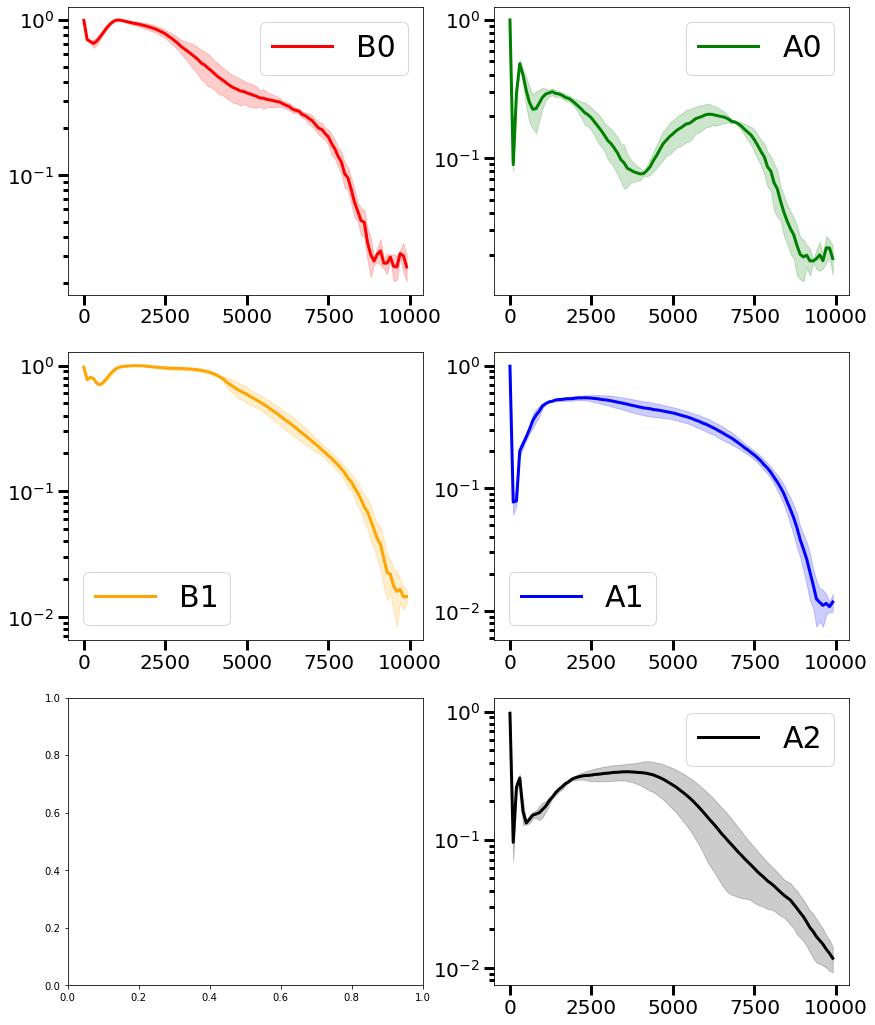

In [10]:

####################################
# plot distances
####################################

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

fig, axs = plt.subplots(3, 2,figsize = (14, 18))

labels = ['B0', 'B1', None, 'A0', 'A1', 'A2']
colors = ['red','orange',None, 'green','blue','black']

labels = ['B0', 'B1', None, 'A0', 'A1', 'A2']
colors = ['red','orange',None, 'green','blue','black']

#make P plots
for l in range(n_layer):
    for pq in range(2):
        if l==n_layer-1 and pq==0:
            continue
        ax = axs[l,pq]
        dist_p = torch.zeros(len(seeds), max_iters//stride)
        for idx, sd in enumerate(seeds):
            losses[idx,:] = dist_dict[(sd,)][l,pq,:]
        dist_mean = torch.mean(losses, axis=0)
        dist_std = torch.std(losses, axis=0)
        
        style_id = l + 3*pq
        
        ax.plot(range(0,max_iters,stride), dist_mean, color = colors[style_id], lw = 3, label=labels[style_id])
        ax.fill_between(range(0,max_iters,stride), dist_mean-dist_std, dist_mean+dist_std, color = colors[style_id], alpha = 0.2)
        #ax.set_xlabel('Iteration',fontsize=40)
        ax.tick_params(axis='both', which='major', labelsize=20, width = 3, length = 10)
        ax.tick_params(axis='both', which='minor', labelsize=20, width = 3, length = 5)
        ax.legend(fontsize=30)
        ax.set_yscale('log')

plt.savefig(fig_dir + '/simple_demonstration_dist_to_id.pdf', dpi=600)


In [9]:
print((hist_dict[(0,)][100]- hist_dict[(1,)][100]).norm())
print((compute_dist_identity(hist_dict[(0,)][100][i,0,j,:,:]) - compute_dist_identity(hist_dict[(1,)][100][i,0,j,:,:])))
print((dist_dict[(0,)][0,0,10]- dist_dict[(1,)][0,0,10]).norm())


tensor(0.45, device='cuda:0')
0.029331311583518982
tensor(0.00)
